In [87]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

# from leitmotifs.lama import *

import pandas as pd
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
def read_data():
    df = pd.read_csv("../tests/results/scalability_20240903-112414.csv", index_col=0)    
    return df

df = read_data()
df.head()

,backend,time in s,memory in MB
length,,,
10000,default,20.318927,1912.562500
10000,scalable,19.621105,775.156250
10000,pyattimo,33.360764,884.109375
20000,default,4.455208,6963.800781
20000,scalable,8.726424,1262.320312


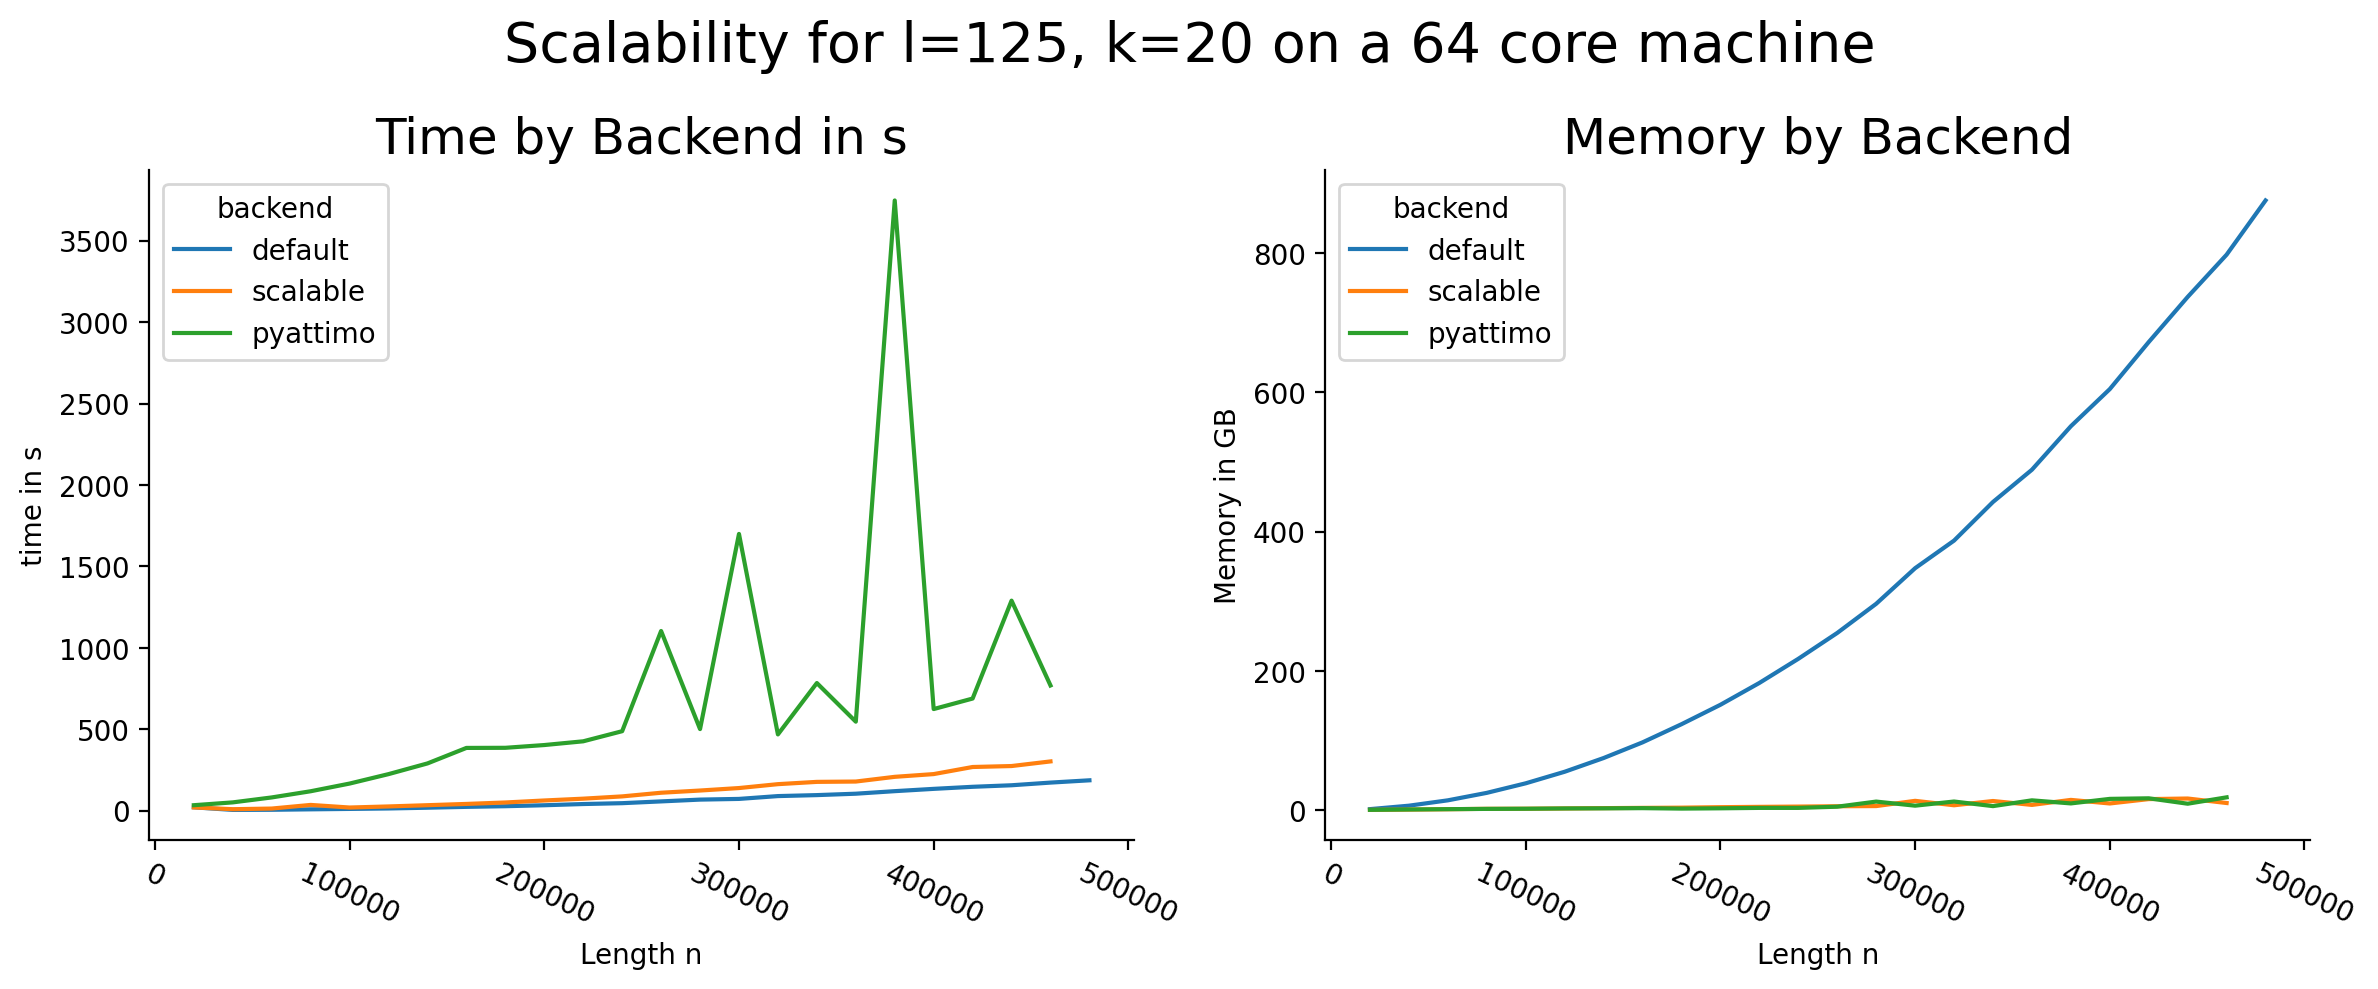

In [152]:
df = read_data()

df.index = df.index*2
df["memory in MB"] = df["memory in MB"] / 1024

mask = df.backend=="default"
subset = df[mask] 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(x=df.index, hue=df.backend, y=df["time in s"], ax=axes[0])
axes[0].set_title("Time by Backend in s", fontsize=18)
axes[0].tick_params(axis='x', labelrotation=-25)
axes[0].set_xlabel("Length n")

plt.yticks(fontsize=10)
plt.ylabel("Time in s")
sns.despine()

sns.lineplot(x=df.index, hue=df.backend, y=df["memory in MB"], ax=axes[1])
axes[1].set_title("Memory by Backend", fontsize=18)
axes[1].tick_params(axis='x', labelrotation=-25)
axes[1].set_xlabel("Length n")
axes[1].set_ylabel("Memory in GB")

plt.yticks(fontsize=10)
sns.despine()

plt.suptitle("Scalability for l=125, k=20 on a 64 core machine", fontsize=20)
plt.tight_layout()
plt.savefig("../tests/results/images/scalability.pdf")

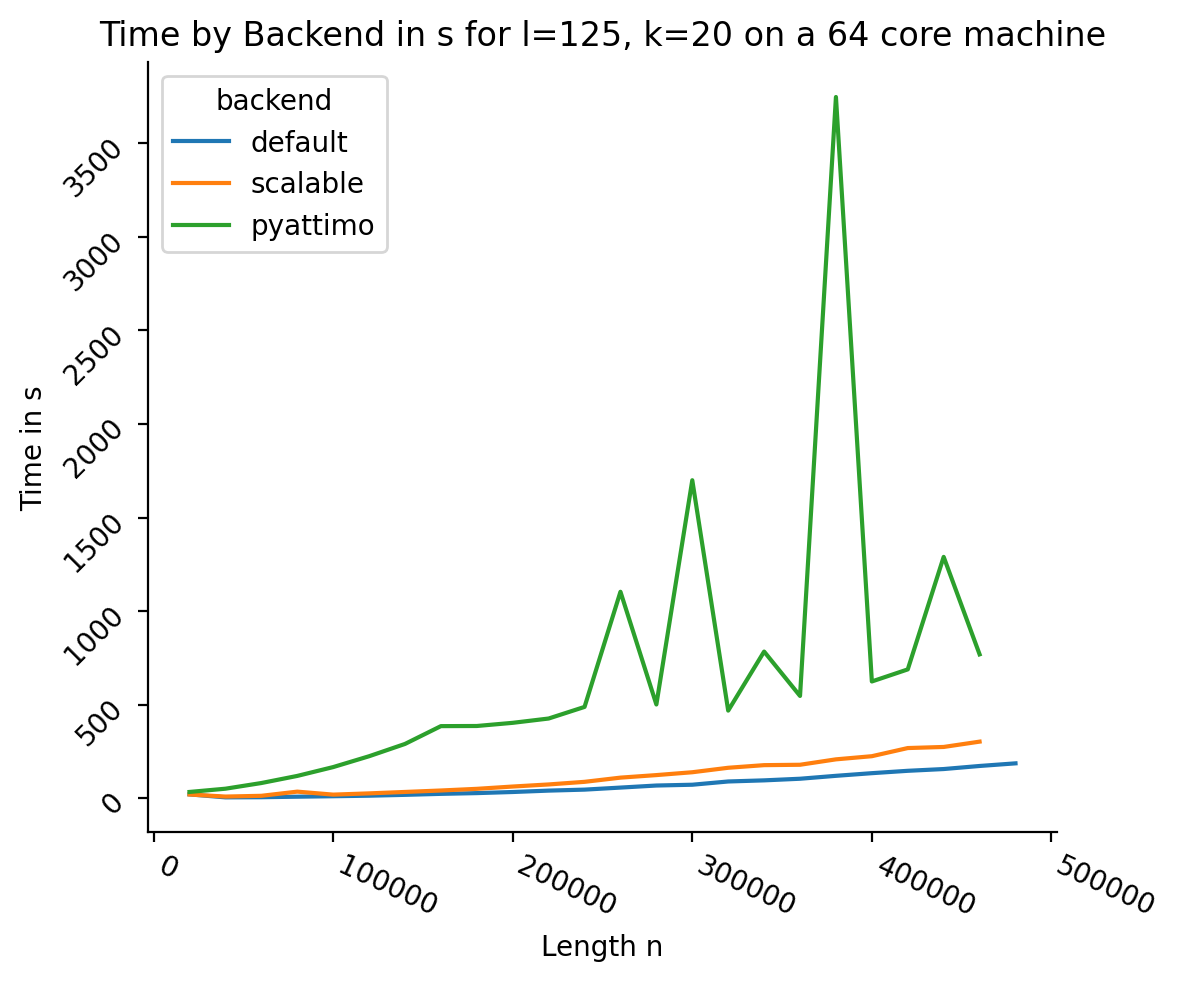

In [151]:
df = read_data()

df.index = df.index*2

fig, axes = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(x=df.index, hue=df.backend, y=df["time in s"], ax=axes)
axes.set_title("Time by Backend in s for l=125, k=20 on a 64 core machine", fontsize=12)
axes.tick_params(labelrotation=45)

plt.yticks(fontsize=10)
plt.xticks(rotation=-25, fontsize=10, ha='left')
plt.xlabel("Length n")
plt.ylabel("Time in s")
sns.despine()

plt.tight_layout()
plt.savefig("../tests/results/images/scalability_runtime.pdf")

In [144]:
n = (380_000 ** 2) * 4 / (1024 * 1024 * 1024)
n


537.9319190979004